In [1]:
import sfc_ml_pipeline as sfc
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd


In [2]:
data_folder = "data/raw"
all_data = sfc.load_all_files(data_folder, sep="\t")


In [3]:
#sfc.plot_all_signals(all_data)


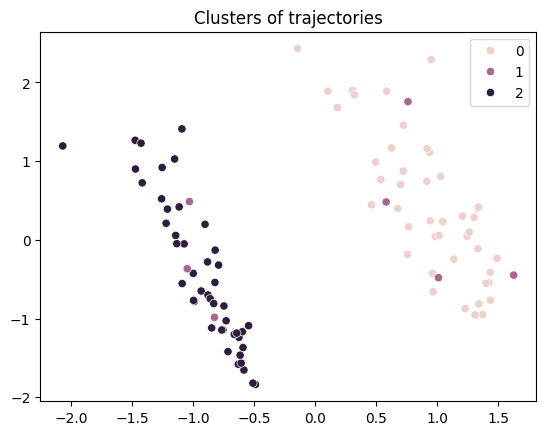

In [4]:
features = sfc.extract_features_per_file(all_data)
features, scaler, kmeans = sfc.cluster_features(features, n_clusters=3)

# Plot clusters
X_scaled = scaler.transform(features.drop(["filename", "cluster"], axis=1))
sfc.plot_clusters(X_scaled, features["cluster"].values)


In [5]:
features = sfc.extract_features_per_file(all_data)
features, scaler, kmeans = sfc.cluster_features(features, n_clusters=3)
print(features["cluster"].value_counts())


cluster
2    46
0    45
1     7
Name: count, dtype: int64


In [6]:
# Filter out noisy cluster (e.g. cluster 2)
clean_features = features[features["cluster"] != 2].copy()


In [7]:
import json

cluster_map = dict(zip(clean_features["filename"], clean_features["cluster"]))

with open("file_cluster_map.json", "w") as f:
    json.dump(cluster_map, f, indent=2)

print(f"Saved file_cluster_map.json with {len(cluster_map)} files.")


Saved file_cluster_map.json with 52 files.


In [8]:
with open("file_cluster_map.json") as f:
    cluster_map = json.load(f)


In [9]:
# Load cluster map
import json

with open("file_cluster_map.json") as f:
    cluster_map = json.load(f)

# Pick cluster 0 and cluster 1 separately
cluster_files = {
    0: [f for f, c in cluster_map.items() if c == 0],
    1: [f for f, c in cluster_map.items() if c == 1]
}

print("Files in Cluster 0:", cluster_files[0])
print("Files in Cluster 1:", cluster_files[1])

# We'll store all X and y for each cluster
X_all_clusters = {}
y_all_clusters = {}

# Define your input and output variables
y_cols = ["T_PM", "c", "d10", "d50", "d90", "T_TM"]
u_cols = ["mf_PM", "mf_TM", "Q_g", "w_crystal", "c_in", "T_PM_in", "T_TM_in"]

# Import the lagged dataset function from analysis_utils
from analysis_utils import create_lagged_dataset

# For each cluster
for cluster_id in [0, 1]:
    X_list = []
    y_list = []

    for fname in cluster_files[cluster_id]:
        df_file = all_data[fname]

        # Create lagged X and y for this file
        X, y = create_lagged_dataset(
            df_file,
            y_cols,
            u_cols,
            n_lags=5
        )

        if len(X) > 0:
            X_list.append(X)
            y_list.append(y)

    if len(X_list) > 0:
        X_all = np.vstack(X_list)
        y_all = np.vstack(y_list)
    else:
        X_all = np.empty((0, 5 * (len(y_cols) + len(u_cols))))
        y_all = np.empty((0, len(y_cols)))

    X_all_clusters[cluster_id] = X_all
    y_all_clusters[cluster_id] = y_all

    print(f"Cluster {cluster_id} → X shape: {X_all.shape}, y shape: {y_all.shape}")


Files in Cluster 0: ['file_73559.txt', 'file_83091.txt', 'file_81731.txt', 'file_20658.txt', 'file_38361.txt', 'file_55007.txt', 'file_56250.txt', 'file_39455.txt', 'file_65538.txt', 'file_54097.txt', 'file_46647.txt', 'file_16361.txt', 'file_77600.txt', 'file_29351.txt', 'file_61276.txt', 'file_42685.txt', 'file_56035.txt', 'file_96991.txt', 'file_34890.txt', 'file_79990.txt', 'file_58631.txt', 'file_71331.txt', 'file_20785.txt', 'file_28440.txt', 'file_51551.txt', 'file_50501.txt', 'file_3834.txt', 'file_57858.txt', 'file_550.txt', 'file_25611.txt', 'file_20726.txt', 'file_54059.txt', 'file_62851.txt', 'file_9985.txt', 'file_15576.txt', 'file_2345.txt', 'file_74771.txt', 'file_62881.txt', 'file_67537.txt', 'file_69268.txt', 'file_27517.txt', 'file_15229.txt', 'file_43864.txt', 'file_26408.txt', 'file_55801.txt']
Files in Cluster 1: ['file_96463.txt', 'file_3742.txt', 'file_22620.txt', 'file_971.txt', 'file_22636.txt', 'file_41551.txt', 'file_92454.txt']
Cluster 0 → X shape: (44775, 6

In [10]:
X_all_clusters[0].shape


(44775, 65)

In [11]:
X_all_clusters[0].shape

(44775, 65)

In [12]:
from sklearn.model_selection import train_test_split

# Example for cluster 0:
X_train, X_test, y_train, y_test = train_test_split(
    X_all_clusters[0],
    y_all_clusters[0],
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (35820, 65)
Test shape: (8955, 65)


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Define a simple NARX feedforward network
class NARXNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [14]:
# Convert numpy arrays to torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_train_torch, y_train_torch)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Create model
model = NARXNet(input_dim=X_train.shape[1], output_dim=y_train.shape[1])

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 300
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} - Loss {loss.item():.6f}")


Epoch    0 - Loss 1.708153
Epoch   50 - Loss 0.235842
Epoch  100 - Loss 0.271190
Epoch  150 - Loss 0.206061
Epoch  200 - Loss 0.166141
Epoch  250 - Loss 0.113526


In [15]:
# Evaluate on test set
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_pred = model(X_test_torch).detach().numpy()

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Test MSE: 0.07441155300893587


In [16]:
torch.save(model.state_dict(), "model_cluster0.pt")


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all_clusters[1],
    y_all_clusters[1],
    test_size=0.2,
    random_state=42
)

torch.save(model.state_dict(), "model_cluster1.pt")


In [26]:
#hopefully final ANN please

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


class NARXNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)


from analysis_utils import create_lagged_dataset

# Change n_lags as desired
n_lags = 10

X_all_clusters = {}
y_all_clusters = {}

for cluster_id in [0, 1]:
    X_list = []
    y_list = []

    for fname in cluster_files[cluster_id]:
        df_file = all_data[fname]
        X, y = create_lagged_dataset(
            df_file,
            y_cols,
            u_cols,
            n_lags=n_lags
        )
        if len(X) > 0:
            X_list.append(X)
            y_list.append(y)

    if len(X_list) > 0:
        X_all = np.vstack(X_list)
        y_all = np.vstack(y_list)
    else:
        X_all = np.empty((0, n_lags * (len(y_cols) + len(u_cols))))
        y_all = np.empty((0, len(y_cols)))

    X_all_clusters[cluster_id] = X_all
    y_all_clusters[cluster_id] = y_all

    print(f"Cluster {cluster_id} → X shape: {X_all.shape}, y shape: {y_all.shape}")
y_scalers = {}
models = {}

for cluster_id in [0, 1]:
    print(f"\n=== TRAINING NARXNet FOR CLUSTER {cluster_id} ===")

    X = X_all_clusters[cluster_id]
    y = y_all_clusters[cluster_id]

    if X.shape[0] == 0:
        print(f"Cluster {cluster_id} has no data. Skipping.")
        continue

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale y
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    y_scalers[cluster_id] = y_scaler

    # Prepare DataLoader
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)

    dataset = TensorDataset(X_train_torch, y_train_torch)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Define model
    model = NARXNet(
        input_dim=X_train.shape[1],
        output_dim=y_train.shape[1]
    )

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    # Training loop
    epochs = 1000
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 100 == 0:
            avg_loss = running_loss / len(loader)
            print(f"[Cluster {cluster_id}] Epoch {epoch:4d} - Avg Loss {avg_loss:.6f}")

    # Predict on test set
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)
    y_pred_scaled = model(X_test_torch).detach().numpy()
    y_pred_original = y_scaler.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_test, y_pred_original)
    r2 = r2_score(y_test, y_pred_original)

    print(f"[Cluster {cluster_id}] Test MSE: {mse:.6f}")
    print(f"[Cluster {cluster_id}] Test R²: {r2:.6f}")

    # Save model
    torch.save(model.state_dict(), f"model_cluster{cluster_id}.pt")
    print(f"Model saved: model_cluster{cluster_id}.pt")

    models[cluster_id] = model


/Users/mayankchandra/Downloads/Lectures/MLME/Project/MLME/analysis_utils.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
/Users/mayankchandra/Downloads/Lectures/MLME/Project/MLME/analysis_utils.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
/Users/mayankchandra/Downloads/Lectures/MLME/Project/MLME/analysis_utils.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

Cluster 0 → X shape: (44550, 130), y shape: (44550, 6)
Cluster 1 → X shape: (6930, 130), y shape: (6930, 6)

=== TRAINING NARXNet FOR CLUSTER 0 ===
[Cluster 0] Epoch    0 - Avg Loss 2.413044
[Cluster 0] Epoch  100 - Avg Loss 0.556862
[Cluster 0] Epoch  200 - Avg Loss 0.548590
[Cluster 0] Epoch  300 - Avg Loss 0.533275
[Cluster 0] Epoch  400 - Avg Loss 0.535191
[Cluster 0] Epoch  500 - Avg Loss 0.527783
[Cluster 0] Epoch  600 - Avg Loss 0.529442
[Cluster 0] Epoch  700 - Avg Loss 0.524701
[Cluster 0] Epoch  800 - Avg Loss 0.523969
[Cluster 0] Epoch  900 - Avg Loss 0.522648
[Cluster 0] Test MSE: 0.035505
[Cluster 0] Test R²: 0.483766
Model saved: model_cluster0.pt

=== TRAINING NARXNet FOR CLUSTER 1 ===
[Cluster 1] Epoch    0 - Avg Loss 52.337214
[Cluster 1] Epoch  100 - Avg Loss 0.672765
[Cluster 1] Epoch  200 - Avg Loss 0.640011
[Cluster 1] Epoch  300 - Avg Loss 0.620061
[Cluster 1] Epoch  400 - Avg Loss 0.611346
[Cluster 1] Epoch  500 - Avg Loss 0.613418
[Cluster 1] Epoch  600 - Avg Lo

In [27]:
import joblib

for cluster_id, scaler in y_scalers.items():
    joblib.dump(scaler, f"y_scaler_cluster{cluster_id}.pkl")
    print(f"Scaler saved for cluster {cluster_id}.")


Scaler saved for cluster 0.
Scaler saved for cluster 1.


In [28]:
import joblib

# Save scaler for cluster 0
joblib.dump(y_scalers[0], "y_scaler_cluster0.pkl")

# Save scaler for cluster 1
joblib.dump(y_scalers[1], "y_scaler_cluster1.pkl")


['y_scaler_cluster1.pkl']

In [29]:
#1. Prediction Pipeline For New Data
import torch
import numpy as np
import joblib
from analysis_utils import create_lagged_dataset

def predict_for_new_file(
    fname,
    cluster_id,
    model_path,
    scaler_path,
    n_lags=10
):
    """
    Predict outputs for a single new file using trained NARX model.
    """

    # Load new file
    df_new = all_data[fname]

    # Create lagged features
    X_new, _ = create_lagged_dataset(
        df_new,
        y_cols,
        u_cols,
        n_lags=n_lags
    )

    if X_new.shape[0] == 0:
        print("Not enough data points in file for chosen lags.")
        return None

    # Load trained model
    model = NARXNet(input_dim=X_new.shape[1], output_dim=len(y_cols))
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load scaler
    scaler = joblib.load(scaler_path)

    # Predict
    X_new_torch = torch.tensor(X_new, dtype=torch.float32)
    y_pred_scaled = model(X_new_torch).detach().numpy()
    y_pred_original = scaler.inverse_transform(y_pred_scaled)

    return y_pred_original


In [32]:
class PinballLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        e = y_true - y_pred
        return torch.mean(torch.max(
            self.quantile * e,
            (self.quantile - 1) * e
        ))


In [33]:
class NARXNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)



=== CQR for Cluster 0 ===
[Cluster 0] Lower model Epoch 0
[Cluster 0] Lower model Epoch 50
[Cluster 0] Lower model Epoch 100
[Cluster 0] Lower model Epoch 150
[Cluster 0] Lower model Epoch 200
[Cluster 0] Lower model Epoch 250
[Cluster 0] Upper model Epoch 0
[Cluster 0] Upper model Epoch 50
[Cluster 0] Upper model Epoch 100
[Cluster 0] Upper model Epoch 150
[Cluster 0] Upper model Epoch 200
[Cluster 0] Upper model Epoch 250
[Cluster 0] Empirical coverage: 0.924


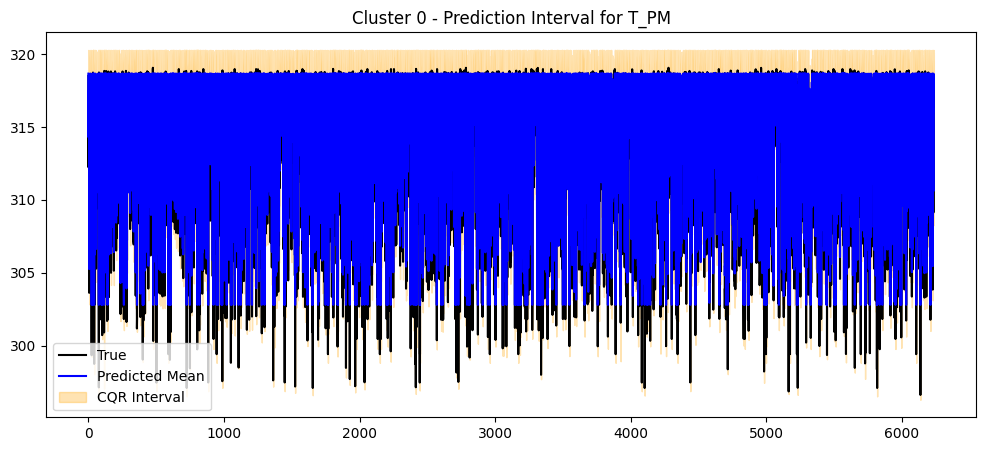

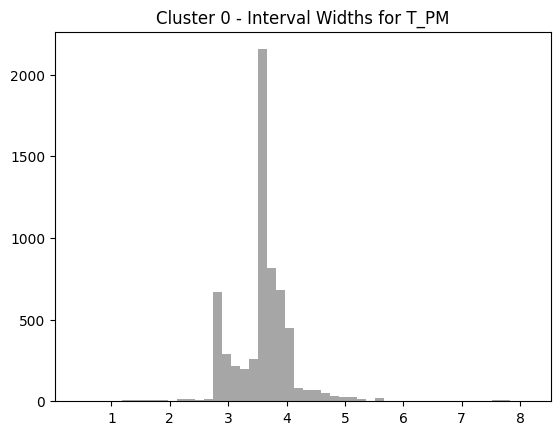


=== CQR for Cluster 1 ===
[Cluster 1] Lower model Epoch 0
[Cluster 1] Lower model Epoch 50
[Cluster 1] Lower model Epoch 100
[Cluster 1] Lower model Epoch 150
[Cluster 1] Lower model Epoch 200
[Cluster 1] Lower model Epoch 250
[Cluster 1] Upper model Epoch 0
[Cluster 1] Upper model Epoch 50
[Cluster 1] Upper model Epoch 100
[Cluster 1] Upper model Epoch 150
[Cluster 1] Upper model Epoch 200
[Cluster 1] Upper model Epoch 250
[Cluster 1] Empirical coverage: 0.986


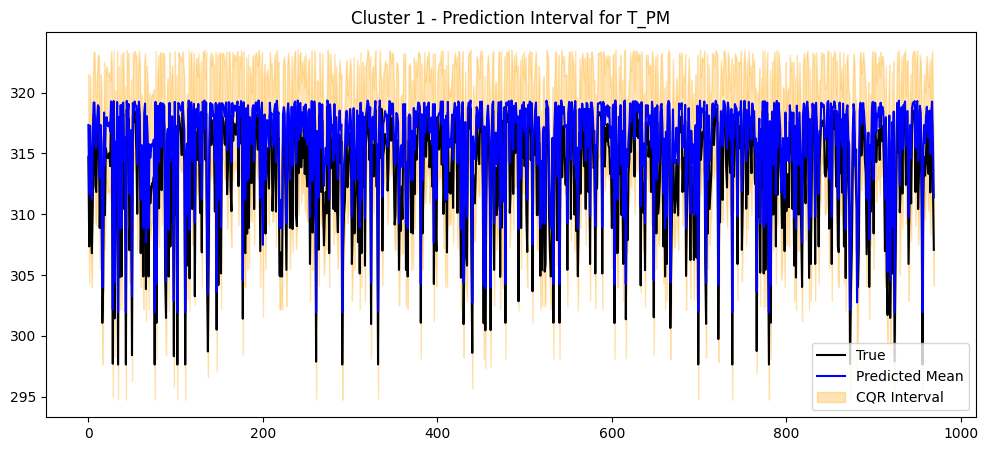

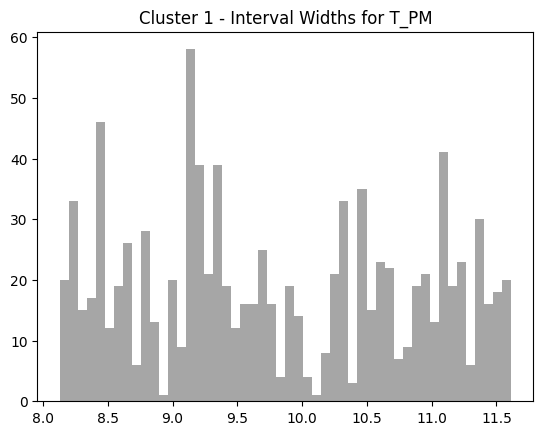

In [34]:
# Import everything
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Pinball loss function
class PinballLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        e = y_true - y_pred
        return torch.mean(torch.max(
            self.quantile * e,
            (self.quantile - 1) * e
        ))

# Your NARX model definition
class NARXNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Run CQR pipeline for both clusters
for cluster_id in [0, 1]:
    print(f"\n=== CQR for Cluster {cluster_id} ===")

    X = X_all_clusters[cluster_id]
    y = y_all_clusters[cluster_id]

    if X.shape[0] == 0:
        print(f"Cluster {cluster_id} has no data. Skipping.")
        continue

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Further split test into test_model and calibration
    X_test_model, X_calib, y_test_model, y_calib = train_test_split(
        X_test, y_test, test_size=0.3, random_state=42
    )

    # Scale y
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_model_scaled = scaler.transform(y_test_model)
    y_calib_scaled = scaler.transform(y_calib)

    # Torch data
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_train_torch, y_train_torch)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # --- Train Lower Quantile Model (0.1) ---
    model_lower = NARXNet(X_train.shape[1], y_train.shape[1])
    loss_fn_lower = PinballLoss(quantile=0.1)
    optimizer_lower = torch.optim.Adam(model_lower.parameters(), lr=5e-4)

    for epoch in range(300):
        for xb, yb in loader:
            pred = model_lower(xb)
            loss = loss_fn_lower(pred, yb)
            optimizer_lower.zero_grad()
            loss.backward()
            optimizer_lower.step()
        if epoch % 50 == 0:
            print(f"[Cluster {cluster_id}] Lower model Epoch {epoch}")

    # --- Train Upper Quantile Model (0.9) ---
    model_upper = NARXNet(X_train.shape[1], y_train.shape[1])
    loss_fn_upper = PinballLoss(quantile=0.9)
    optimizer_upper = torch.optim.Adam(model_upper.parameters(), lr=5e-4)

    for epoch in range(300):
        for xb, yb in loader:
            pred = model_upper(xb)
            loss = loss_fn_upper(pred, yb)
            optimizer_upper.zero_grad()
            loss.backward()
            optimizer_upper.step()
        if epoch % 50 == 0:
            print(f"[Cluster {cluster_id}] Upper model Epoch {epoch}")

    # Predict on calibration set
    X_calib_torch = torch.tensor(X_calib, dtype=torch.float32)
    pred_lower_calib_scaled = model_lower(X_calib_torch).detach().numpy()
    pred_upper_calib_scaled = model_upper(X_calib_torch).detach().numpy()

    pred_lower_calib = scaler.inverse_transform(pred_lower_calib_scaled)
    pred_upper_calib = scaler.inverse_transform(pred_upper_calib_scaled)

    # Compute residuals
    errors_lower = y_calib - pred_lower_calib
    errors_upper = pred_upper_calib - y_calib

    # Compute quantile adjustment
    q_level = 0.9
    quantile_error_lower = np.quantile(errors_lower, q_level, axis=0)
    quantile_error_upper = np.quantile(errors_upper, q_level, axis=0)

    # Predict on test_model
    X_test_model_torch = torch.tensor(X_test_model, dtype=torch.float32)
    pred_lower_test_scaled = model_lower(X_test_model_torch).detach().numpy()
    pred_upper_test_scaled = model_upper(X_test_model_torch).detach().numpy()

    pred_lower_test = scaler.inverse_transform(pred_lower_test_scaled)
    pred_upper_test = scaler.inverse_transform(pred_upper_test_scaled)

    # Apply conformal adjustment
    final_lower = pred_lower_test - quantile_error_lower
    final_upper = pred_upper_test + quantile_error_upper

    # Predict mean model for reference (reuse upper model for now as a placeholder)
    pred_mean_test = scaler.inverse_transform(pred_upper_test_scaled)

    # Evaluate coverage
    inside = np.logical_and(
        y_test_model >= final_lower,
        y_test_model <= final_upper
    )
    coverage = np.mean(np.all(inside, axis=1))
    print(f"[Cluster {cluster_id}] Empirical coverage: {coverage:.3f}")

    # Plot one output variable
    var_idx = 0  # e.g. T_PM

    plt.figure(figsize=(12, 5))
    plt.plot(y_test_model[:, var_idx], label="True", color="black")
    plt.plot(pred_mean_test[:, var_idx], label="Predicted Mean", color="blue")
    plt.fill_between(
        np.arange(len(y_test_model)),
        final_lower[:, var_idx],
        final_upper[:, var_idx],
        color="orange",
        alpha=0.3,
        label="CQR Interval"
    )
    plt.legend()
    plt.title(f"Cluster {cluster_id} - Prediction Interval for {y_cols[var_idx]}")
    plt.show()

    # Plot interval widths
    interval_widths = final_upper - final_lower
    plt.hist(interval_widths[:, var_idx], bins=50, color='gray', alpha=0.7)
    plt.title(f"Cluster {cluster_id} - Interval Widths for {y_cols[var_idx]}")
    plt.show()


In [36]:
mean_width = np.mean(final_upper - final_lower, axis=0)
for var, w in zip(y_cols, mean_width):
    print(f"{var}: Average interval width = {w:.3f}")


T_PM: Average interval width = 16.895
c: Average interval width = 0.037
d10: Average interval width = 0.139
d50: Average interval width = 0.127
d90: Average interval width = 0.163
T_TM: Average interval width = 17.710



=== CQR for Cluster 0 ===
[Cluster 0] Lower model Epoch 0
[Cluster 0] Lower model Epoch 50
[Cluster 0] Lower model Epoch 100
[Cluster 0] Lower model Epoch 150
[Cluster 0] Lower model Epoch 200
[Cluster 0] Lower model Epoch 250
[Cluster 0] Upper model Epoch 0
[Cluster 0] Upper model Epoch 50
[Cluster 0] Upper model Epoch 100
[Cluster 0] Upper model Epoch 150
[Cluster 0] Upper model Epoch 200
[Cluster 0] Upper model Epoch 250
[Cluster 0] Empirical coverage: 0.991


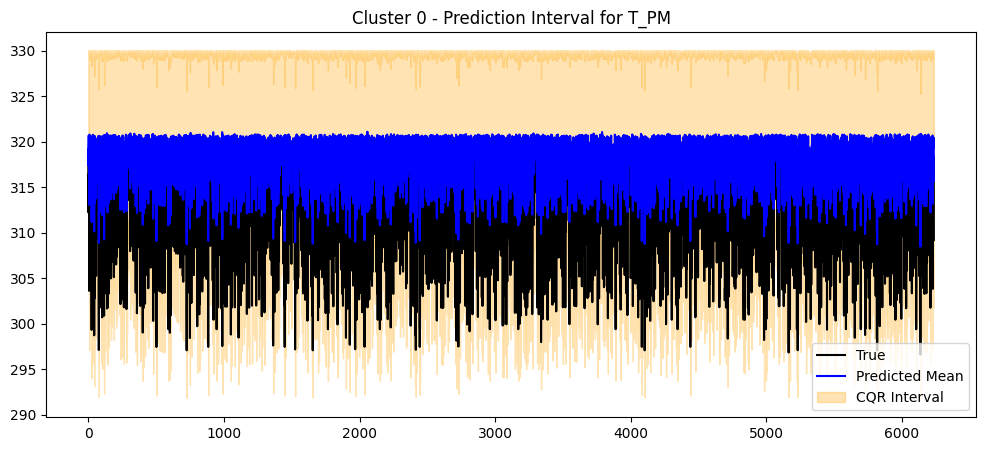

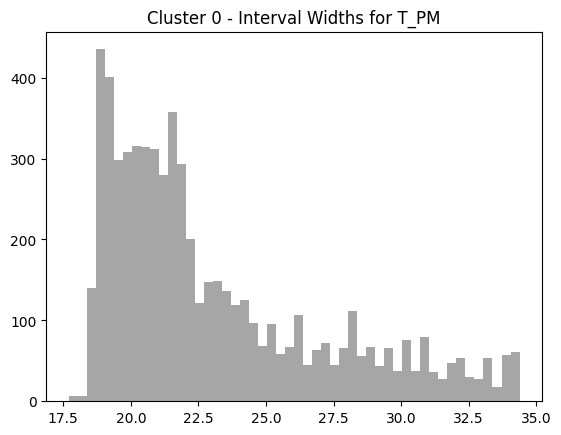

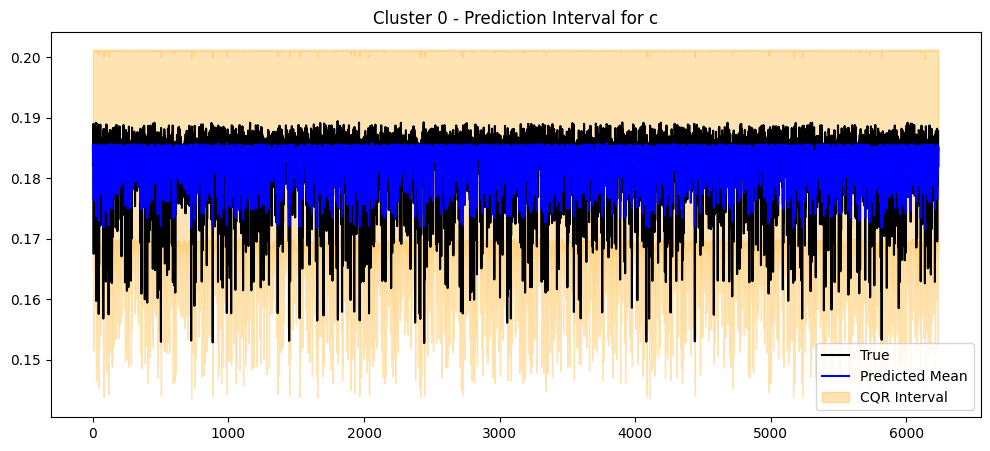

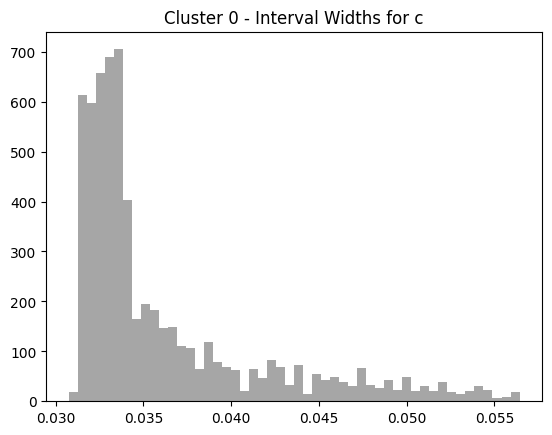

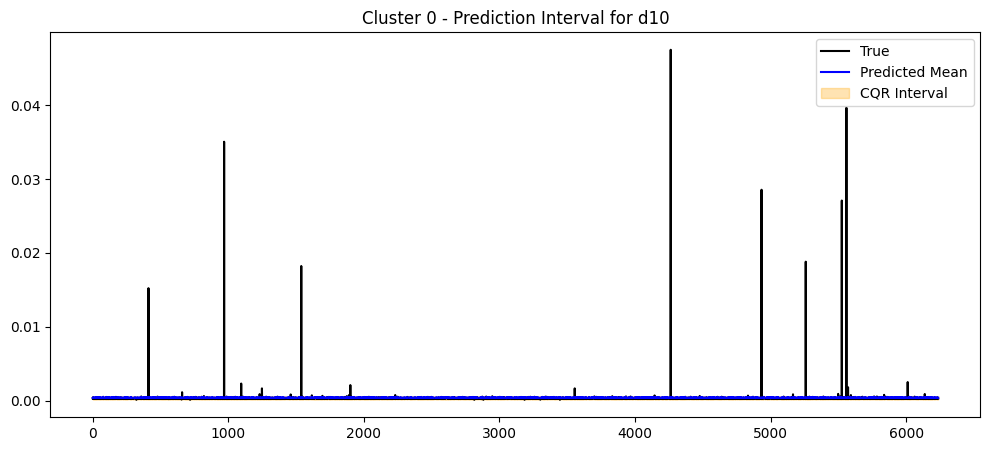

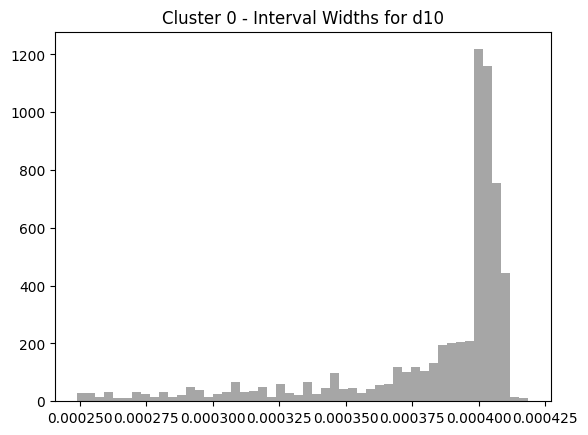

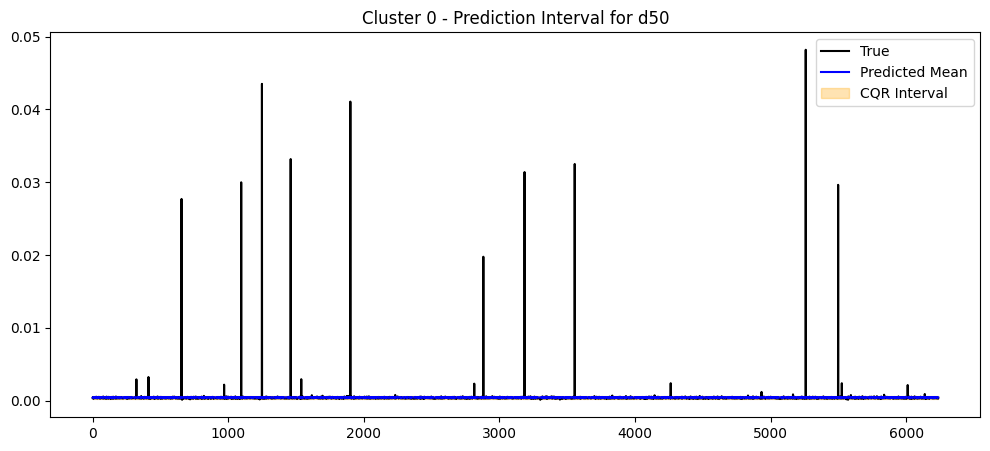

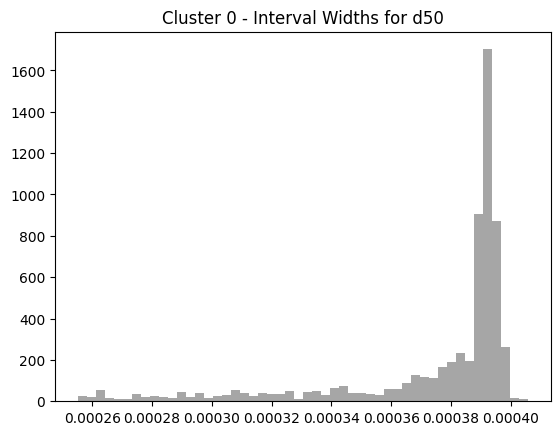

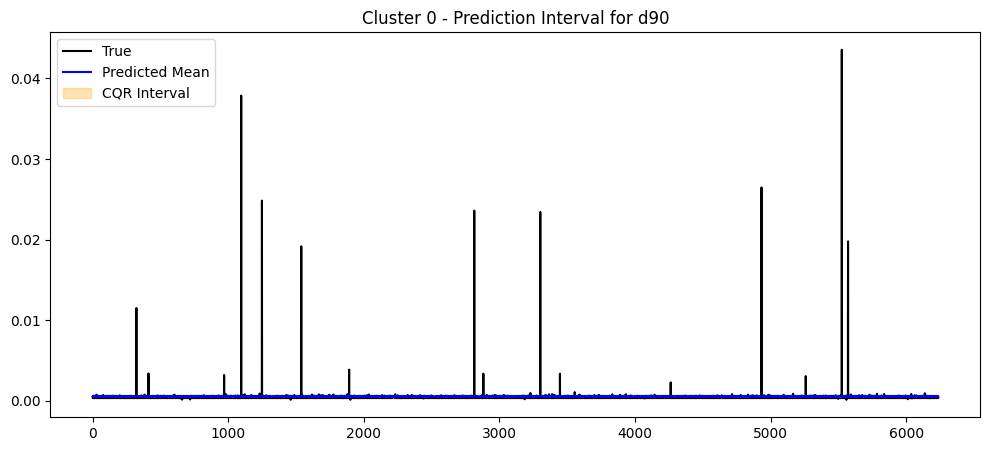

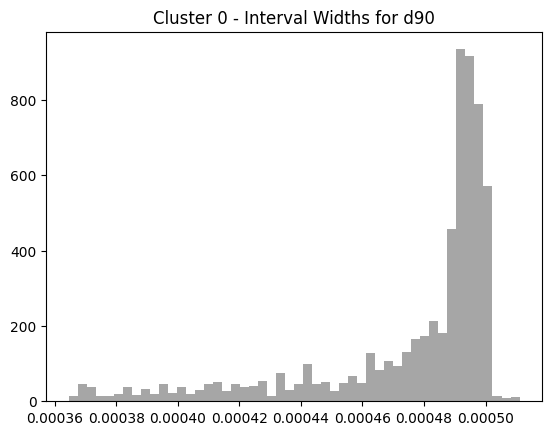

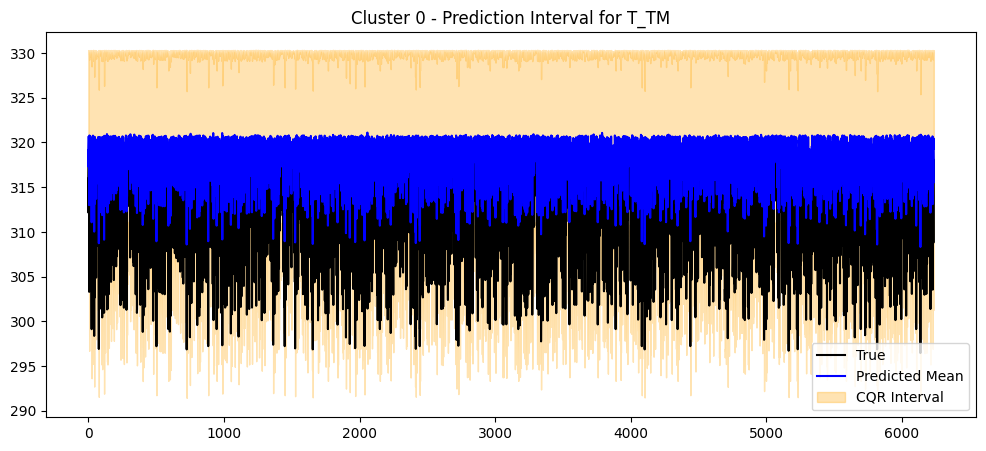

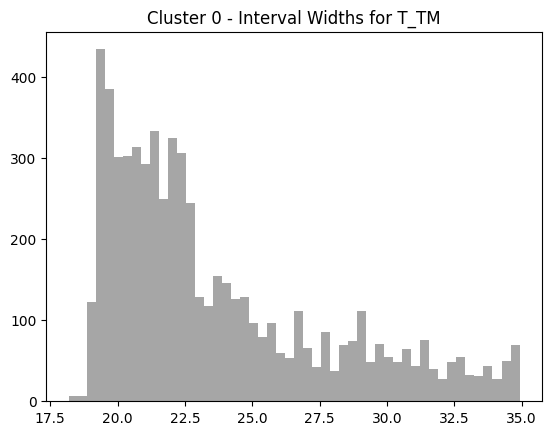


=== CQR for Cluster 1 ===
[Cluster 1] Lower model Epoch 0
[Cluster 1] Lower model Epoch 50
[Cluster 1] Lower model Epoch 100
[Cluster 1] Lower model Epoch 150
[Cluster 1] Lower model Epoch 200
[Cluster 1] Lower model Epoch 250
[Cluster 1] Upper model Epoch 0
[Cluster 1] Upper model Epoch 50
[Cluster 1] Upper model Epoch 100
[Cluster 1] Upper model Epoch 150
[Cluster 1] Upper model Epoch 200
[Cluster 1] Upper model Epoch 250
[Cluster 1] Empirical coverage: 0.952


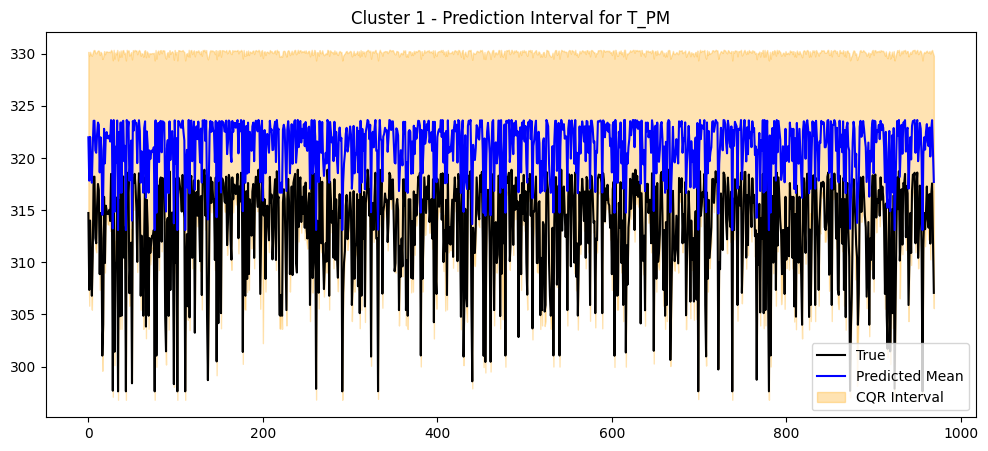

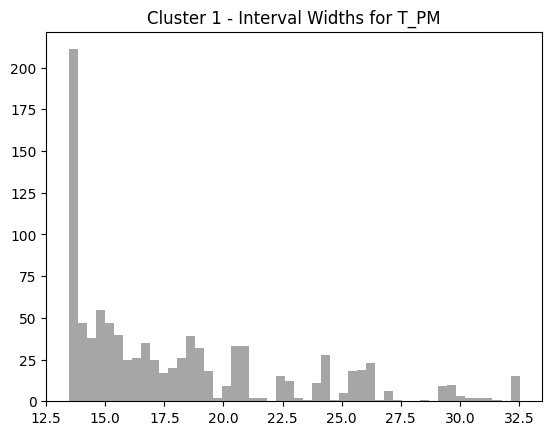

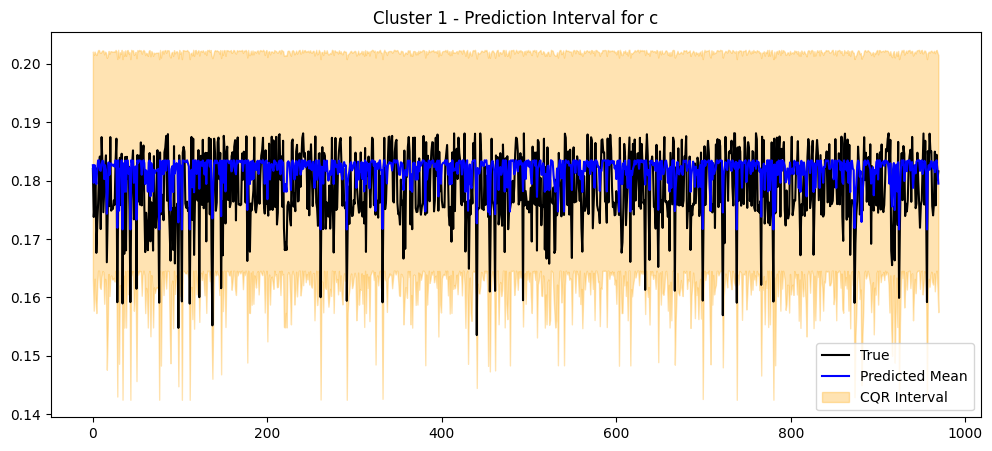

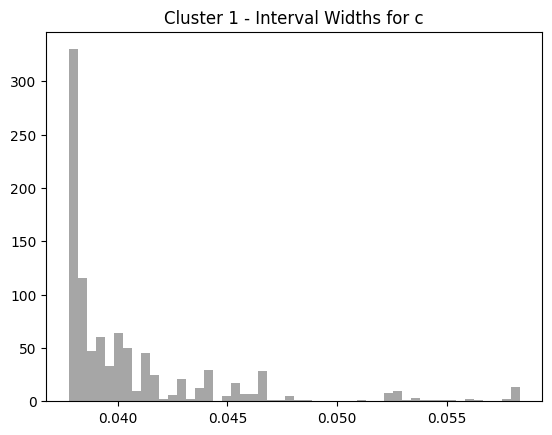

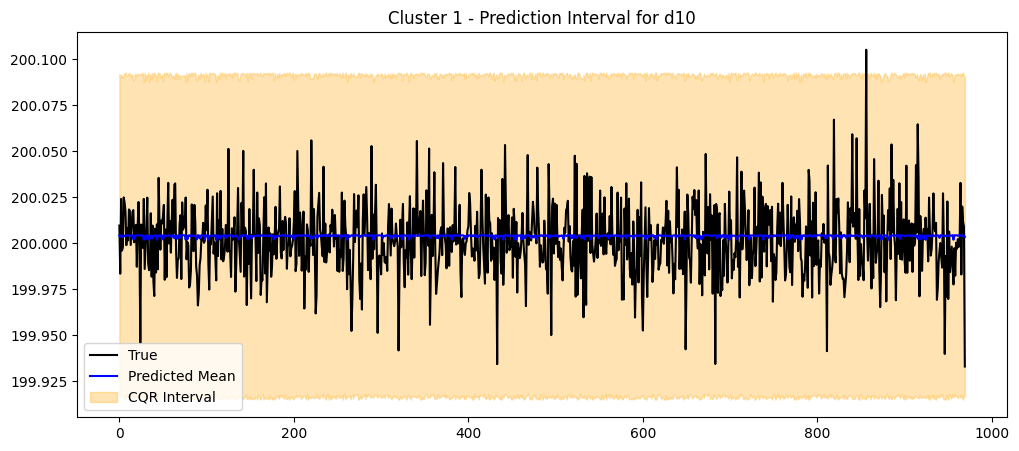

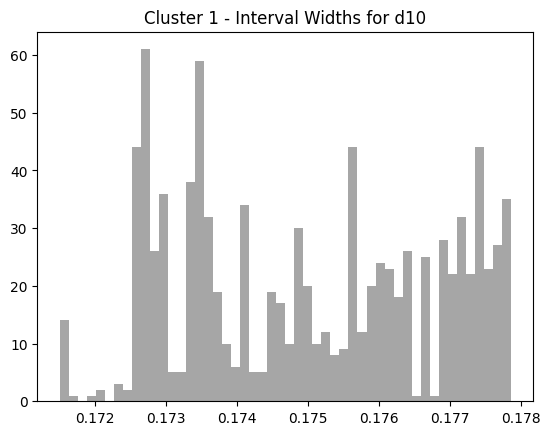

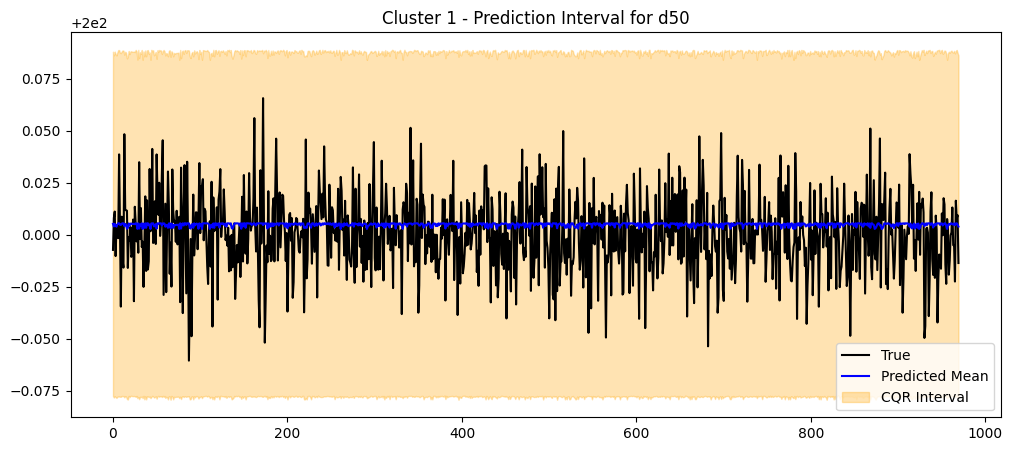

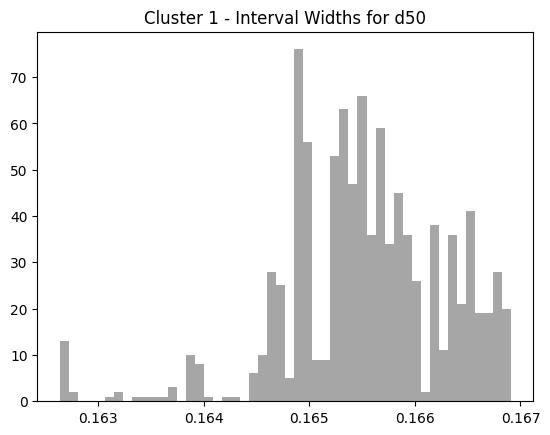

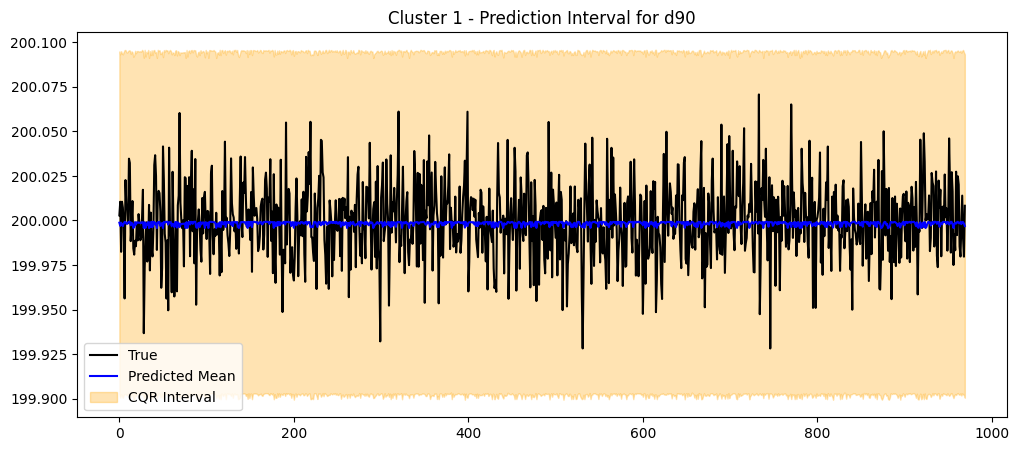

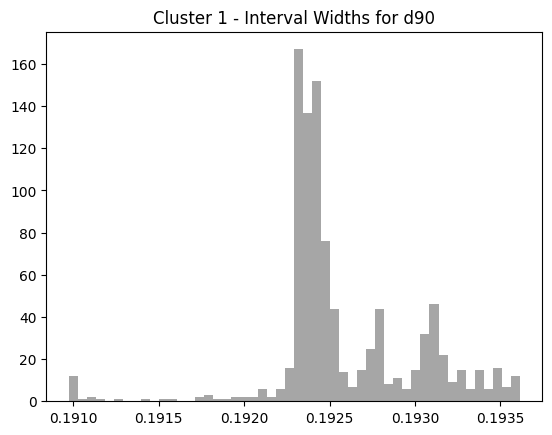

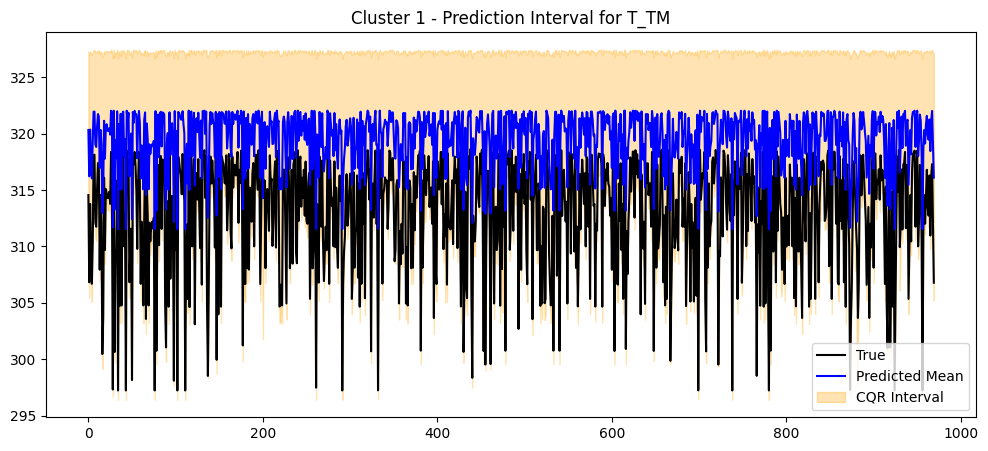

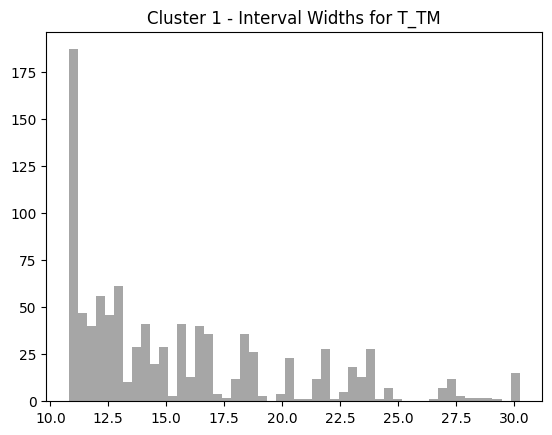

In [37]:
#new hopefully CQR

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Pinball loss
class PinballLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        e = y_true - y_pred
        return torch.mean(torch.max(
            self.quantile * e,
            (self.quantile - 1) * e
        ))

# NARX model
class NARXNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Run CQR for both clusters
for cluster_id in [0, 1]:
    print(f"\n=== CQR for Cluster {cluster_id} ===")

    X = X_all_clusters[cluster_id]
    y = y_all_clusters[cluster_id]

    if X.shape[0] == 0:
        print(f"Cluster {cluster_id} has no data. Skipping.")
        continue

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Further split test into test_model and calibration
    X_test_model, X_calib, y_test_model, y_calib = train_test_split(
        X_test, y_test, test_size=0.3, random_state=42
    )

    # Scale y
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_model_scaled = scaler.transform(y_test_model)
    y_calib_scaled = scaler.transform(y_calib)

    # Save scaler
    joblib.dump(scaler, f"y_scaler_cluster{cluster_id}_cqr.pkl")

    # Prepare Torch DataLoader
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
    dataset = TensorDataset(X_train_torch, y_train_torch)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    # --- Train Lower Quantile Model (0.05) ---
    model_lower = NARXNet(X_train.shape[1], y_train.shape[1])
    loss_fn_lower = PinballLoss(quantile=0.05)
    optimizer_lower = torch.optim.Adam(model_lower.parameters(), lr=5e-4)

    for epoch in range(300):
        for xb, yb in loader:
            pred = model_lower(xb)
            loss = loss_fn_lower(pred, yb)
            optimizer_lower.zero_grad()
            loss.backward()
            optimizer_lower.step()
        if epoch % 50 == 0:
            print(f"[Cluster {cluster_id}] Lower model Epoch {epoch}")

    torch.save(model_lower.state_dict(), f"model_cluster{cluster_id}_q05.pt")

    # --- Train Upper Quantile Model (0.95) ---
    model_upper = NARXNet(X_train.shape[1], y_train.shape[1])
    loss_fn_upper = PinballLoss(quantile=0.95)
    optimizer_upper = torch.optim.Adam(model_upper.parameters(), lr=5e-4)

    for epoch in range(300):
        for xb, yb in loader:
            pred = model_upper(xb)
            loss = loss_fn_upper(pred, yb)
            optimizer_upper.zero_grad()
            loss.backward()
            optimizer_upper.step()
        if epoch % 50 == 0:
            print(f"[Cluster {cluster_id}] Upper model Epoch {epoch}")

    torch.save(model_upper.state_dict(), f"model_cluster{cluster_id}_q95.pt")

    # Predict on calibration set
    X_calib_torch = torch.tensor(X_calib, dtype=torch.float32)
    pred_lower_calib_scaled = model_lower(X_calib_torch).detach().numpy()
    pred_upper_calib_scaled = model_upper(X_calib_torch).detach().numpy()

    pred_lower_calib = scaler.inverse_transform(pred_lower_calib_scaled)
    pred_upper_calib = scaler.inverse_transform(pred_upper_calib_scaled)

    # Compute residuals
    errors_lower = y_calib - pred_lower_calib
    errors_upper = pred_upper_calib - y_calib

    # Compute conformal adjustment for 90% coverage
    q_level = 0.9
    quantile_error_lower = np.quantile(errors_lower, q_level, axis=0)
    quantile_error_upper = np.quantile(errors_upper, q_level, axis=0)

    # Predict on test_model
    X_test_model_torch = torch.tensor(X_test_model, dtype=torch.float32)
    pred_lower_test_scaled = model_lower(X_test_model_torch).detach().numpy()
    pred_upper_test_scaled = model_upper(X_test_model_torch).detach().numpy()

    pred_lower_test = scaler.inverse_transform(pred_lower_test_scaled)
    pred_upper_test = scaler.inverse_transform(pred_upper_test_scaled)

    # Apply conformal adjustment
    final_lower = pred_lower_test - quantile_error_lower
    final_upper = pred_upper_test + quantile_error_upper

    # Predict mean for plotting as midpoint
    pred_mean_test = (final_lower + final_upper) / 2

    # Evaluate empirical coverage
    inside = np.logical_and(
        y_test_model >= final_lower,
        y_test_model <= final_upper
    )
    coverage = np.mean(np.all(inside, axis=1))
    print(f"[Cluster {cluster_id}] Empirical coverage: {coverage:.3f}")

    # Plot results for all variables
    for var_idx in range(y_test_model.shape[1]):
        var_name = y_cols[var_idx]
        plt.figure(figsize=(12, 5))
        plt.plot(y_test_model[:, var_idx], label="True", color="black")
        plt.plot(pred_mean_test[:, var_idx], label="Predicted Mean", color="blue")
        plt.fill_between(
            np.arange(len(y_test_model)),
            final_lower[:, var_idx],
            final_upper[:, var_idx],
            color="orange",
            alpha=0.3,
            label="CQR Interval"
        )
        plt.legend()
        plt.title(f"Cluster {cluster_id} - Prediction Interval for {var_name}")
        plt.show()

        interval_widths = final_upper[:, var_idx] - final_lower[:, var_idx]
        plt.hist(interval_widths, bins=50, color='gray', alpha=0.7)
        plt.title(f"Cluster {cluster_id} - Interval Widths for {var_name}")
        plt.show()
